In [ ]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62.6 MB 1.3 MB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 1.7 MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=6751560 sha256=8de81c6b60d924e1857eb8ed1ac49d56e43685dcb2723755799eaea0a5cccc06
  Stored in directory: /root/.cache/pip/wheels/d0/d2/ae/c579b7fd160999d35908f3cb8ebcad7ef64ecaca7b78e4c3c8
Successfully built fbprophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 1.0.8
    Uninstalling cmdstanpy-1.0.8:
      Successfully uninstalled cmdstanpy-1.0.8
ERROR: pip's dependency resolver does not currently take into account all the 

In [ ]:
import itertools
from fbprophet import Prophet
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet.diagnostics import cross_validation , performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

In [ ]:
df = pd.read_csv('VOF.L.csv', usecols=[0,4])
df.head()

,Date,Close
0,12/28/2017,326.00
1,12/29/2017,331.75
2,1/2/2018,342.00
3,1/3/2018,352.00
4,1/4/2018,350.00


In [ ]:
df.shape

(1262, 2)

In [ ]:
df.describe()

,Close
count,1262.000000
mean,387.623811
std,74.004481
min,214.000000
25%,331.000000
50%,348.250000
75%,459.375000
max,545.000000


In [ ]:
df.Date = pd.to_datetime(df.Date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1262 entries, 0 to 1261
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1262 non-null   datetime64[ns]
 1   Close   1262 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


In [ ]:
import plotly.express as px
fig = px.line(df, x='Date', y='Close')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
df = df.rename(columns = {"Date":"ds","Close":"y"})
df.head()

,ds,y
0,2017-12-28,326.00
1,2017-12-29,331.75
2,2018-01-02,342.00
3,2018-01-03,352.00
4,2018-01-04,350.00


In [ ]:
test_days = int(len(df)*0.2)
training_set = df.iloc[:-test_days, :]
test_set = df.iloc[-test_days:, :]

### 1. Baseline Model Using Default Hyperparameters

In [ ]:
# Initiate the model
baseline_model = Prophet()

# Fit the model on the training dataset
baseline_model.fit(training_set)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
baseline_model_cv = cross_validation(model=baseline_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
baseline_model_cv.head()

INFO:fbprophet:Making 41 forecasts with cutoffs between 2018-08-10 00:00:00 and 2021-11-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f68438d3340>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-08-13,322.438838,316.921715,327.890855,326.0,2018-08-10
1,2018-08-14,320.142493,314.226321,325.528687,325.0,2018-08-10
2,2018-08-15,320.512529,314.704363,326.043894,325.0,2018-08-10
3,2018-08-16,318.626638,312.642957,324.017786,326.0,2018-08-10
4,2018-08-17,318.145553,312.597156,323.724727,323.0,2018-08-10


In [ ]:
# Model performance metrics
baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
baseline_model_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,30 days,2562.162273,50.617806,28.853081,0.082372,0.050575,0.290739


In [ ]:
# Get the performance metric value
baseline_model_p['mape'].values[0]

0.08237159922079641

### 2. Automatic Hyperparameter Tuning

In [ ]:
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Create a list to store MAPE values for each combination
mapes = [] 

# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(training_set)  
    # Cross-validation
    df_cv = cross_validation(m, initial='500 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 31 forecasts with cutoffs between 2019-06-06 00:00:00 and 2021-11-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f683d345a30>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 31 forecasts with cutoffs between 2019-06-06 00:00:00 and 2021-11-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f683dc2e790>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 31 forecasts with cutoffs between 2019-06-06 00:00:00 and 2021-11-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f683db73880>
INFO:fbprophet:Disabling daily seasonality. Run p

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [ ]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])

# Fit the model on the training dataset
auto_model.fit(training_set)

# Cross validation
auto_model_cv = cross_validation(auto_model, initial='500 days', period='30 days', horizon = '30 days', parallel="processes")

# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)
auto_model_p['mape'].values[0]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 31 forecasts with cutoffs between 2019-06-06 00:00:00 and 2021-11-22 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f683db62370>


0.04473555199307578

### 3. Predict Test

In [ ]:
future = auto_model.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future = pd.concat([future, df.iloc[:,1:]],
                   axis = 1)
future.tail(5)

,ds,y
1257,2022-08-27,453.0
1258,2022-08-28,445.5
1259,2022-08-29,447.0
1260,2022-08-30,443.0
1261,2022-08-31,443.0


In [ ]:
forecast = auto_model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-12-28,325.447877,331.075911,353.451263,325.447877,325.447877,16.692191,16.692191,16.692191,-0.087662,-0.087662,-0.087662,16.779853,16.779853,16.779853,0.0,0.0,0.0,342.140069
1,2017-12-29,325.950928,332.515432,355.874476,325.950928,325.950928,17.755150,17.755150,17.755150,0.083687,0.083687,0.083687,17.671462,17.671462,17.671462,0.0,0.0,0.0,343.706077
2,2018-01-02,327.963131,337.462629,359.816991,327.963131,327.963131,20.736725,20.736725,20.736725,-0.087494,-0.087494,-0.087494,20.824220,20.824220,20.824220,0.0,0.0,0.0,348.699856
3,2018-01-03,328.466181,338.897645,361.236274,328.466181,328.466181,21.620213,21.620213,21.620213,0.168380,0.168380,0.168380,21.451833,21.451833,21.451833,0.0,0.0,0.0,350.086394
4,2018-01-04,328.969232,338.924932,363.013237,328.969232,328.969232,21.908025,21.908025,21.908025,-0.087662,-0.087662,-0.087662,21.995687,21.995687,21.995687,0.0,0.0,0.0,350.877257


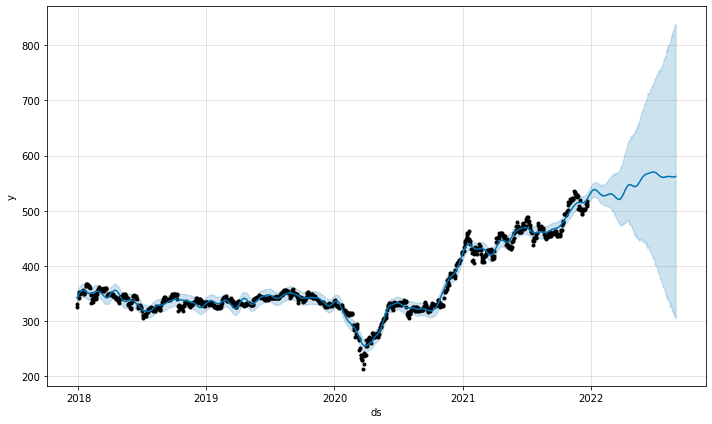

In [ ]:
auto_model.plot(forecast);

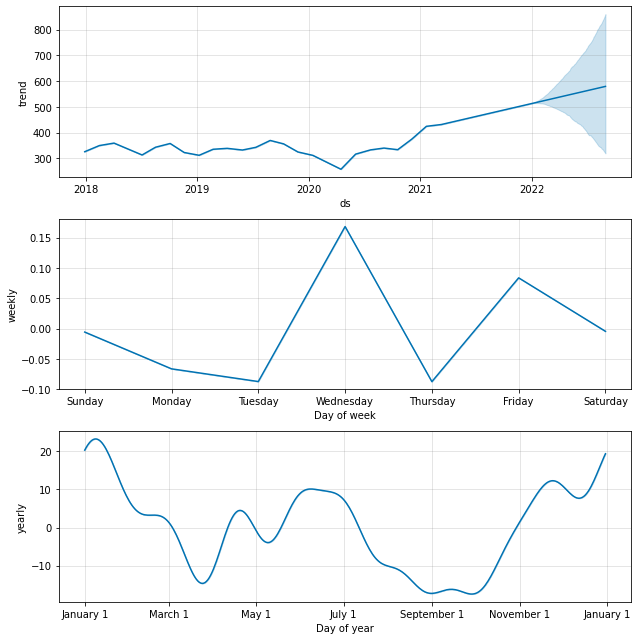

In [ ]:
auto_model.plot_components(forecast);

In [ ]:
predictions = pd.DataFrame(forecast.yhat[-test_days:])
predictions.set_index = test_set['ds']
predictions

,yhat
1010,522.466322
1011,523.757213
1012,524.823158
1013,525.998648
1014,527.124485
...,...
1257,561.401409
1258,561.516167
1259,561.611673
1260,561.786723


In [ ]:
import matplotlib.pyplot as plt

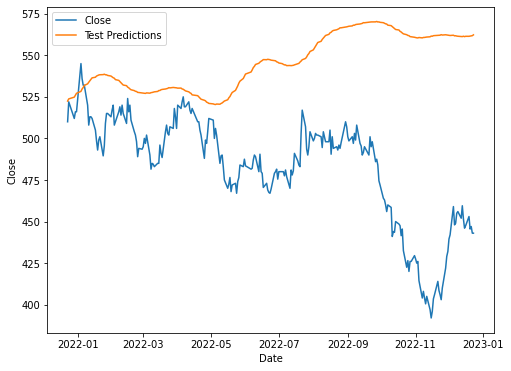

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(test_set.ds, test_set.y, label='Close')
plt.plot(test_set.ds, predictions, label='Test Predictions')
plt.ylabel('Close')
plt.xlabel('Date')
plt.legend()
plt.savefig('testPROPHET.png')
plt.show()

In [ ]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(test_set.y, predictions.yhat))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 77.38 RMSE


In [ ]:
print('Test r2 score:', r2_score(test_set.y, predictions.yhat))
print('Test mean absolute error:', mean_absolute_error(test_set.y, predictions.yhat))
print('Test mean absolute percentage error:', mean_absolute_percentage_error(test_set.y, predictions.yhat))

Test r2 score: -4.783726294021315
Test mean absolute error: 64.3520706630938
Test mean absolute percentage error: 0.14023263685618917


### 4. forecast future

In [ ]:
final_auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'])

# Fit the model on the training dataset
final_auto_model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future2 = final_auto_model.make_future_dataframe(periods = 30,
                                 freq = "D")
future2 = pd.concat([future2, df.iloc[:,1:]],
                   axis = 1)
future2.tail(5)

,ds,y
1287,2023-01-18,NaN
1288,2023-01-19,NaN
1289,2023-01-20,NaN
1290,2023-01-21,NaN
1291,2023-01-22,NaN


In [ ]:
forecast2 = final_auto_model.predict(future2)
forecast2.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-12-28,357.783281,335.595468,362.841742,357.783281,357.783281,-8.984307,-8.984307,-8.984307,-0.120501,-0.120501,-0.120501,-8.863806,-8.863806,-8.863806,0.0,0.0,0.0,348.798974
1,2017-12-29,357.773927,336.787880,364.274870,357.773927,357.773927,-8.035098,-8.035098,-8.035098,0.432306,0.432306,0.432306,-8.467404,-8.467404,-8.467404,0.0,0.0,0.0,349.738828
2,2018-01-02,357.736509,337.184466,363.736037,357.736509,357.736509,-6.876622,-6.876622,-6.876622,-0.022364,-0.022364,-0.022364,-6.854258,-6.854258,-6.854258,0.0,0.0,0.0,350.859888
3,2018-01-03,357.727155,338.128236,364.856596,357.727155,357.727155,-6.380756,-6.380756,-6.380756,0.099849,0.099849,0.099849,-6.480605,-6.480605,-6.480605,0.0,0.0,0.0,351.346399
4,2018-01-04,357.717801,338.437741,365.349403,357.717801,357.717801,-6.253641,-6.253641,-6.253641,-0.120501,-0.120501,-0.120501,-6.133140,-6.133140,-6.133140,0.0,0.0,0.0,351.464160


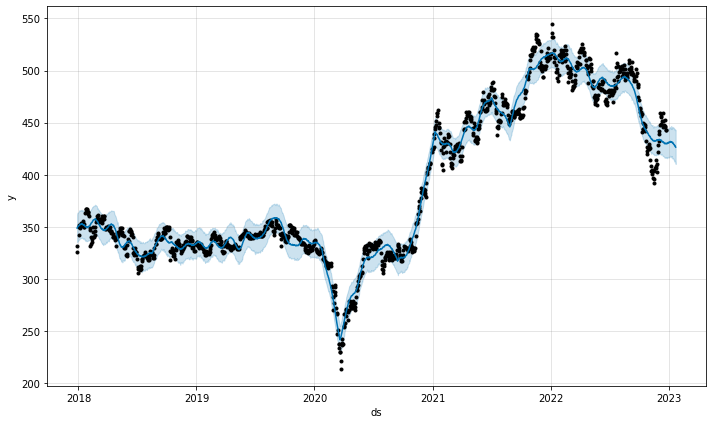

In [ ]:
final_auto_model.plot(forecast2);

In [ ]:
preditcions2 = pd.DataFrame(forecast2.yhat[-30:])

In [ ]:
preditcions2

,yhat
1262,429.887081
1263,429.933199
1264,429.634608
1265,430.121240
1266,430.385126
1267,430.324568
1268,431.048811
1269,430.798437
1270,430.962241
1271,430.738290


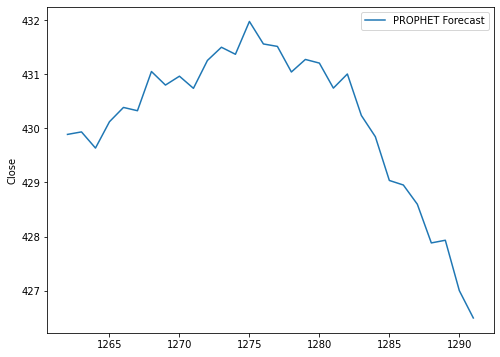

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(preditcions2, label='PROPHET Forecast')
plt.ylabel('Close')
plt.legend()
plt.show()

### 5. Test

In [ ]:
future3 = auto_model.make_future_dataframe(periods = len(test_set)+30,
                                 freq = "D")
future3 = pd.concat([future3, df.iloc[:,1:]],
                   axis = 1)
future3.tail(5)

,ds,y
1287,2022-09-26,NaN
1288,2022-09-27,NaN
1289,2022-09-28,NaN
1290,2022-09-29,NaN
1291,2022-09-30,NaN


In [ ]:
forecast3 = auto_model.predict(future3)

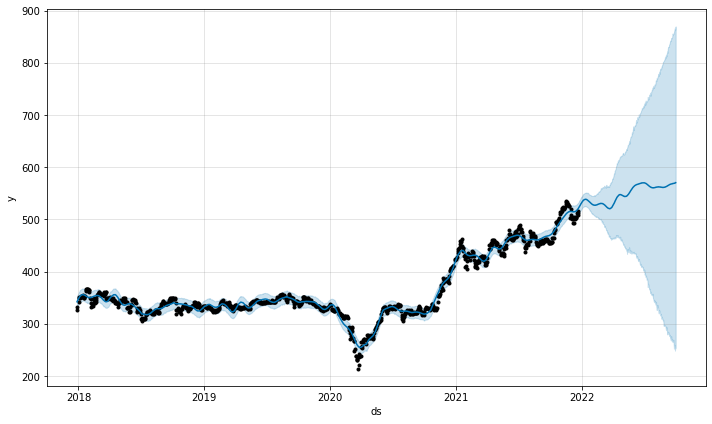

In [ ]:
auto_model.plot(forecast3);

In [ ]:
preditcions3 = pd.DataFrame(forecast3.yhat[-30:])

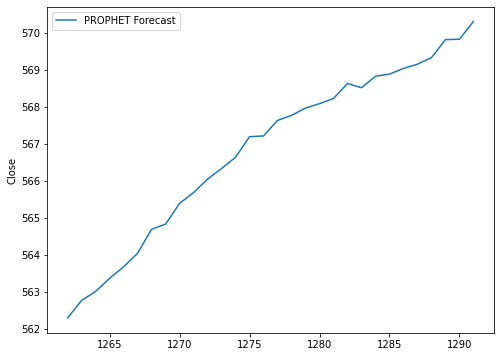

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(preditcions3, label='PROPHET Forecast')
plt.ylabel('Close')
plt.legend()
plt.show()